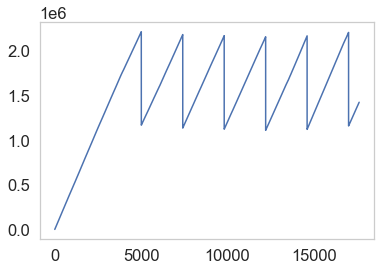

In [35]:
import pandas
import matplotlib.pyplot as plt
usecol = ["Disk_Usage", "Ref_time"]
dataset = pandas.read_csv('kafka_results_wo_compression.csv', usecols=usecol, engine='python')
dataset = dataset.set_index("Ref_time")
#dataset.head(7)
plt.plot(dataset)
plt.show()

In [36]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [37]:
dataframe = pandas.read_csv('kafka_results_wo_compression.csv', usecols=[3])
dataset = dataframe.values
dataset = dataset.astype('float32')
print(dataset)

[[2.800000e+01]
 [9.920000e+02]
 [9.920000e+02]
 ...
 [1.424308e+06]
 [1.424308e+06]
 [1.425268e+06]]


In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [39]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

10529 4513


In [40]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [41]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
trainX

array([[[0.0000000e+00]],

       [[4.3510995e-04]],

       [[4.3510995e-04]],

       ...,

       [[5.2699935e-01]],

       [[5.2699935e-01]],

       [[5.2743268e-01]]], dtype=float32)

In [44]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
10527/10527 - 9s - loss: 0.0116
Epoch 2/100
10527/10527 - 8s - loss: 1.2794e-04
Epoch 3/100
10527/10527 - 8s - loss: 1.1900e-04
Epoch 4/100
10527/10527 - 9s - loss: 1.1011e-04
Epoch 5/100
10527/10527 - 9s - loss: 9.9774e-05
Epoch 6/100
10527/10527 - 8s - loss: 9.8919e-05
Epoch 7/100
10527/10527 - 8s - loss: 9.3058e-05
Epoch 8/100
10527/10527 - 8s - loss: 9.8211e-05
Epoch 9/100
10527/10527 - 7s - loss: 9.7298e-05
Epoch 10/100
10527/10527 - 8s - loss: 9.6289e-05
Epoch 11/100
10527/10527 - 8s - loss: 9.8863e-05
Epoch 12/100
10527/10527 - 8s - loss: 9.8312e-05
Epoch 13/100
10527/10527 - 8s - loss: 9.8196e-05
Epoch 14/100
10527/10527 - 8s - loss: 9.7202e-05
Epoch 15/100
10527/10527 - 8s - loss: 9.8376e-05
Epoch 16/100
10527/10527 - 8s - loss: 9.7946e-05
Epoch 17/100
10527/10527 - 8s - loss: 9.6914e-05
Epoch 18/100
10527/10527 - 7s - loss: 9.7610e-05
Epoch 19/100
10527/10527 - 13s - loss: 9.6939e-05
Epoch 20/100
10527/10527 - 22s - loss: 9.8081e-05
Epoch 21/100
10527/10527 - 17s 

In [45]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [46]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [47]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20397.57 RMSE
Test Score: 22033.94 RMSE


In [48]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [49]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

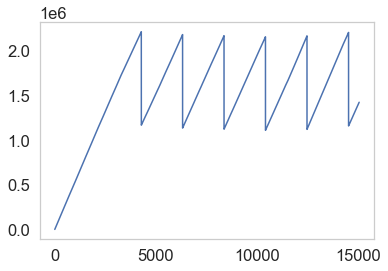

In [50]:
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

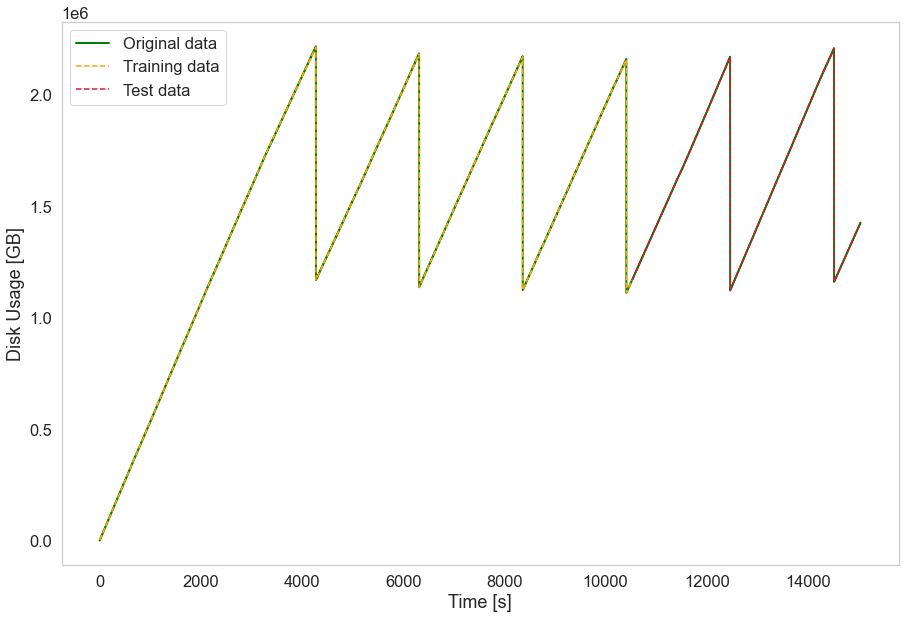

In [51]:
import seaborn as sns
fig3 = plt.figure(figsize=(15, 10))
ax = fig3.add_subplot(1, 1, 1)
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

plt.plot(scaler.inverse_transform(dataset),color = "green", linewidth = 2)
plt.plot(trainPredictPlot, color = "orange", linestyle = "--")
plt.plot(testPredictPlot, color = "crimson", linestyle = "--")
#plt.title("Kafka Model")
plt.legend(["Original data", "Training data", "Test data"])
plt.ylabel("Disk Usage [GB]")
plt.xlabel("Time [s]")

plt.savefig(r"C:\Users\anush\reinfl\reinfl_environment\plots_prediction_models\kafka_lstm_model.png", dpi = 300)
plt.savefig(r"C:\Users\anush\reinfl\reinfl_environment\plots_prediction_models\kafka_lstm_model.pdf", dpi = 300)
plt.show()

In [52]:
x = [[[1.0]]]
model.predict(x)

array([[0.9985386]], dtype=float32)

In [53]:
model.save("Kafka_Model.h5")


In [56]:
import tensorflow
import keras
print(tensorflow.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [62]:
model.predict([[[0]]]).item()

0.0009630024433135986